In [83]:
import pandas as pd
import yfinance as yf
import os
from dotenv import load_dotenv
import fredapi
from fredapi import Fred
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [72]:
api_key = os.getenv('FRED_API_KEY')
fred = Fred(api_key=api_key)

In [77]:
housing_index = fred.get_series('CSUSHPISA')
housing_index = housing_index.dropna()
housing_index

1987-01-01     63.965
1987-02-01     64.425
1987-03-01     64.735
1987-04-01     65.134
1987-05-01     65.569
               ...   
2020-10-01    229.309
2020-11-01    232.560
2020-12-01    235.442
2021-01-01    238.421
2021-02-01    241.130
Length: 410, dtype: float64

<AxesSubplot:title={'center':'Case-Shiller National Home Price Index Historical'}, xlabel='Date', ylabel='Index'>

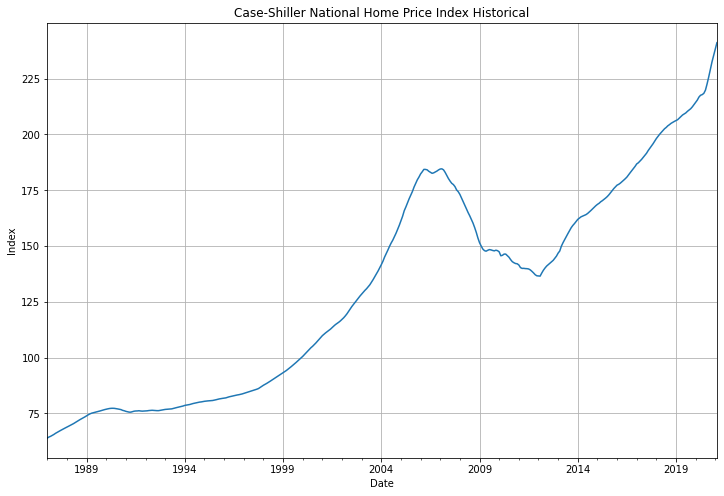

In [89]:
housing_index.plot(figsize=(12,8), title='Case-Shiller National Home Price Index Historical', grid=True, xlabel='Date', ylabel='Index')

In [81]:
# Pull S&P 500 historical data
ticker = "^GSPC" 
start= "1990-01-01" 
end= "2021-05-14"

sp_history = yf.download(ticker, start=start, end=end, progress=False)
sp_history = sp_history.asfreq(freq='D').ffill().dropna()
sp_history.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-01-02,353.399994,359.690002,351.980011,359.690002,359.690002,162070000.0
1990-01-03,359.690002,360.589996,357.890015,358.760010,358.760010,192330000.0
1990-01-04,358.760010,358.760010,352.890015,355.670013,355.670013,177000000.0
1990-01-05,355.670013,355.670013,351.350006,352.200012,352.200012,158530000.0
1990-01-06,355.670013,355.670013,351.350006,352.200012,352.200012,158530000.0


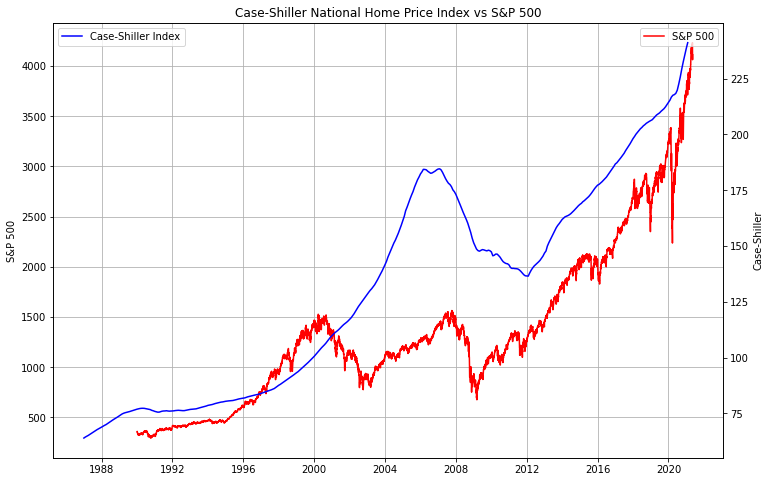

In [91]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(sp_history['Adj Close'], label ='S&P 500', color='r')
ax.set_ylabel('S&P 500')
plt.grid()
ax.legend(loc='upper right')

ax2 = ax.twinx()
plt.plot(housing_index, label='Case-Shiller Index', color='b')
ax.set_title('Case-Shiller National Home Price Index vs S&P 500')
ax2.set_ylabel('Case-Shiller')
ax2.legend(loc='upper left')